# Britannia Stock Price Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Impor data
df_ori = pd.read_csv('BRITANNIA.csv')
df_ori

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,BRITANNIA,EQ,703.25,705.00,759.50,705.0,758.0,756.90,741.01,7512,5.566488e+11,NaN,NaN,NaN
1,2000-01-04,BRITANNIA,EQ,756.90,710.00,770.00,710.0,740.0,754.55,742.52,8135,6.040391e+11,NaN,NaN,NaN
2,2000-01-05,BRITANNIA,EQ,754.55,755.00,759.00,705.0,740.0,735.30,739.92,6095,4.509784e+11,NaN,NaN,NaN
3,2000-01-06,BRITANNIA,EQ,735.30,740.00,794.15,740.0,770.0,785.65,788.83,19697,1.553756e+12,NaN,NaN,NaN
4,2000-01-07,BRITANNIA,EQ,785.65,808.00,848.50,798.0,848.5,848.50,827.53,33107,2.739708e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5300,2021-04-26,BRITANNIA,EQ,3650.30,3661.10,3662.00,3531.0,3546.0,3539.20,3558.62,1031406,3.670382e+14,72258.0,507276.0,0.4918
5301,2021-04-27,BRITANNIA,EQ,3539.20,3572.70,3574.60,3517.0,3546.0,3541.20,3539.42,813608,2.879697e+14,46189.0,322686.0,0.3966
5302,2021-04-28,BRITANNIA,EQ,3541.20,3488.00,3527.00,3469.0,3470.0,3478.75,3495.13,1498181,5.236339e+14,97170.0,763715.0,0.5098
5303,2021-04-29,BRITANNIA,EQ,3478.75,3496.75,3505.90,3447.0,3464.0,3468.90,3471.18,611087,2.121195e+14,41655.0,309653.0,0.5067


In [5]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5305 entries, 0 to 5304
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5305 non-null   object 
 1   Symbol              5305 non-null   object 
 2   Series              5305 non-null   object 
 3   Prev Close          5305 non-null   float64
 4   Open                5305 non-null   float64
 5   High                5305 non-null   float64
 6   Low                 5305 non-null   float64
 7   Last                5305 non-null   float64
 8   Close               5305 non-null   float64
 9   VWAP                5305 non-null   float64
 10  Volume              5305 non-null   int64  
 11  Turnover            5305 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4796 non-null   float64
 14  %Deliverble         4796 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.8

## Data Cleaning

In [12]:
# Kita akan spesifik menggunakan data Prev Close pada 2014
df = df_ori['Prev Close']
df.index = pd.to_datetime(df_ori.Date)
df = df['2014-01-01':'2014-12-31']
df

Date
2014-01-01     920.60
2014-01-02     918.45
2014-01-03     909.20
2014-01-06     916.85
2014-01-07     908.90
               ...   
2014-12-24    1764.10
2014-12-26    1755.40
2014-12-29    1731.15
2014-12-30    1780.20
2014-12-31    1784.00
Name: Prev Close, Length: 244, dtype: float64

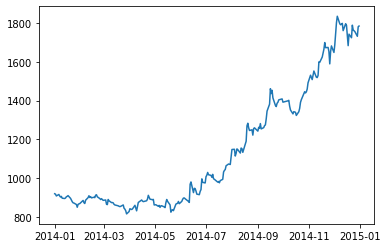

In [13]:
plt.plot(df)
plt.show()

In [26]:
if df.index.freq is None:
    freq = pd.infer_freq(df.index)
    df.index.freq = pd.tseries.frequencies.to_offset(freq)

'freq=None' if df.index.freq is None else df.index.freq

'freq=None'

In [28]:
df = df.asfreq(freq='D')
df.interpolate(inplace=True)
df

Date
2014-01-01     920.600000
2014-01-02     918.450000
2014-01-03     909.200000
2014-01-04     911.750000
2014-01-05     914.300000
                 ...     
2014-12-27    1747.316667
2014-12-28    1739.233333
2014-12-29    1731.150000
2014-12-30    1780.200000
2014-12-31    1784.000000
Freq: D, Name: Prev Close, Length: 365, dtype: float64

## Stationarity Check

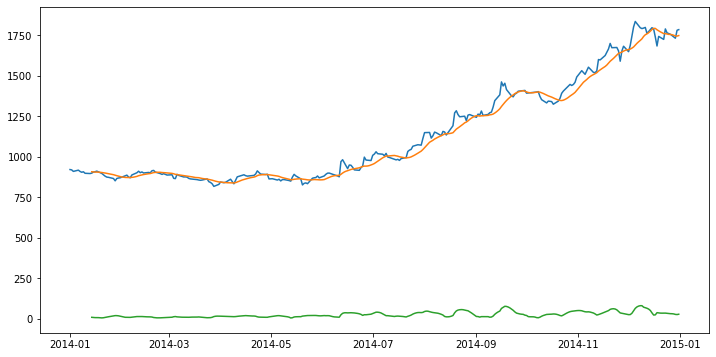

In [32]:
rollingmean = df.rolling(14).mean()
rollingstd = df.rolling(14).std()

plt.figure(figsize=(12, 6))
plt.plot(df, label='Original')
plt.plot(rollingmean, label='Mean')
plt.plot(rollingstd, label='std')
plt.show()